In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.utils.class_weight import compute_sample_weight

In [31]:
seed=9304

In [37]:
data = pd.read_csv('../data/creditcard.csv')

In [46]:
 weight = compute_sample_weight(class_weight='balanced', y=data['Class'])

In [48]:
data['weight'] = weight

In [50]:
data['weight'].value_counts()

0.500865      284315
289.438008       492
Name: weight, dtype: int64

Il modello non è in grado di generalizzare bene. comunque alla fine del tuning nonostante le metriche promettenti in test set performa molto male. Visti gli score di validation probabilmetne il modello è in overfitting.
idee per migliorare:
1) rivedere il feature space. ok in corso. eta meglio upper bound 0.4. forse spegnere reg alfa, lambda  e gamma
2) monitorare il training con la learning_curve di sklearn.
3) migliorare il sampling del modello. o si umentano i boosting round per assicurarsi che il modello riesca a fare abbastanza round da generalizzare il dataset -> monitorare durante il tuning il numero di roud di ogni ciclo di tuning. ok fatto
4) cambiare metodo di sampling. effettuare random undersampling all'inizio.
5) se si usano metodi di sampling disattivare parametri per contollare lo sbilanciamento del target. ok ha funzionato
6) capire comei mplementare l'algoritmo sulla gpu

In [63]:
thresh = pd.read_csv("catboostTuning_data_treshold.csv")

In [64]:
fscore = (2 * thresh['precision'] * thresh['recall']) / (thresh['precision'] + thresh['recall'])
# locate the index of the largest f score
fscore=list(fscore)

In [65]:
fscore_s=sorted(fscore, reverse=True)

In [66]:
thre=[]
for i in range(0, 10):
    thre.append(fscore.index(fscore_s[i]))

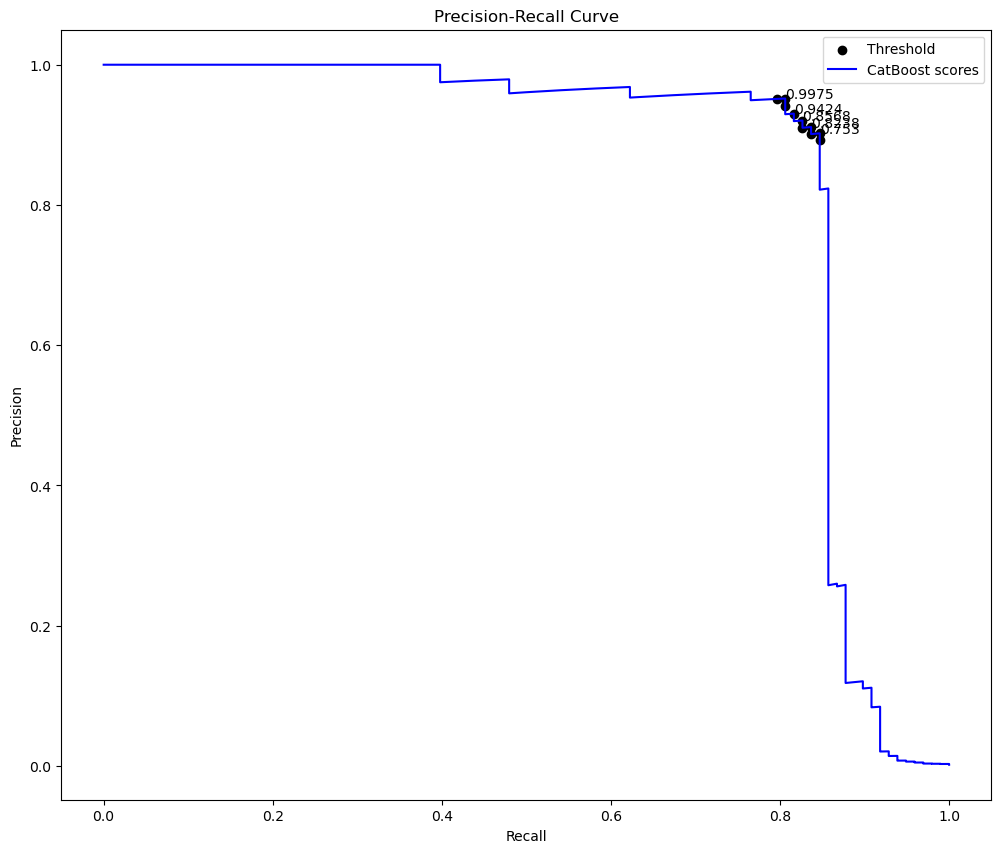

In [67]:
#create precision recall curve
fig, ax = plt.subplots(figsize=(12, 10))
ax.scatter(thresh['recall'][thre], thresh['precision'][thre], marker='o', color='black', label='Threshold')
for i in range(0,5):
    ax.annotate(round(thresh['thresholds'][thre[i]],4), xy=(thresh['recall'][thre][thre[i]], thresh['precision'][thre[i]]))
ax.plot(thresh['recall'], thresh['precision'], color='blue', label='CatBoost scores')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
#display plot
plt.legend()
plt.show()

In [5]:
with open('cb_traials.pkl', 'rb') as f:
    trials=pickle.load(f)

In [32]:
res

[{'state': 2,
  'tid': 0,
  'spec': None,
  'result': {'status': 'ok',
   'loss': 0.2135741002980589,
   'f1_train': 0.9,
   'f1_val': 0.8076923076923078,
   'precision': 0.7974683544303798,
   'recall': 0.8181818181818182},
  'misc': {'tid': 0,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'border_count': [0],
    'depth': [0],
    'grow_policy': [0],
    'l2_leaf_reg': [0],
    'learning_rate': [0],
    'subsample': [0]},
   'vals': {'border_count': [70.0],
    'depth': [7.0],
    'grow_policy': [2],
    'l2_leaf_reg': [11.070981566038379],
    'learning_rate': [0.011944610797129678],
    'subsample': [0.22603939467256068]}},
  'exp_key': None,
  'owner': None,
  'version': 0,
  'book_time': datetime.datetime(2024, 4, 24, 15, 13, 44, 23000),
  'refresh_time': datetime.datetime(2024, 4, 24, 15, 14, 4, 262000)},
 {'state': 2,
  'tid': 1,
  'spec': None,
  'result': {'status': 'ok',
   'loss': 1.1102810325024872,
   'f1_train': 0.3114035087719298,
 

In [8]:
res=trials.trials

In [44]:
min_loss_dict = min(res, key=lambda x: x['result']['loss'])
print(min_loss_dict['misc']['vals'])

{'border_count': [66.0], 'depth': [9.0], 'grow_policy': [1], 'l2_leaf_reg': [2.3036420870406307], 'learning_rate': [0.22202976276765923], 'subsample': [0.016748455397739725]}


In [59]:
best_params={'border_count': 66.0, 
             'depth': 9.0, 
             'grow_policy': 'Lossguide', 
             'l2_leaf_reg': 2.3036420870406307, 
             'learning_rate': 0.22202976276765923, 
             'subsample': 0.016748455397739725,
            }

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
import catboost as cb
import numpy as np

In [40]:
features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'] #'timeFromLastTransaction'

In [60]:
tune_x, test_x, tune_y, test_y = train_test_split(data[features], data['Class'], test_size=0.20, stratify=data['Class'], random_state=seed) # final test split
    
weight = compute_sample_weight(class_weight='balanced', y=tune_y)

In [61]:
final_model = cb.CatBoostClassifier(**best_params)

Confusion matrix on test set: 



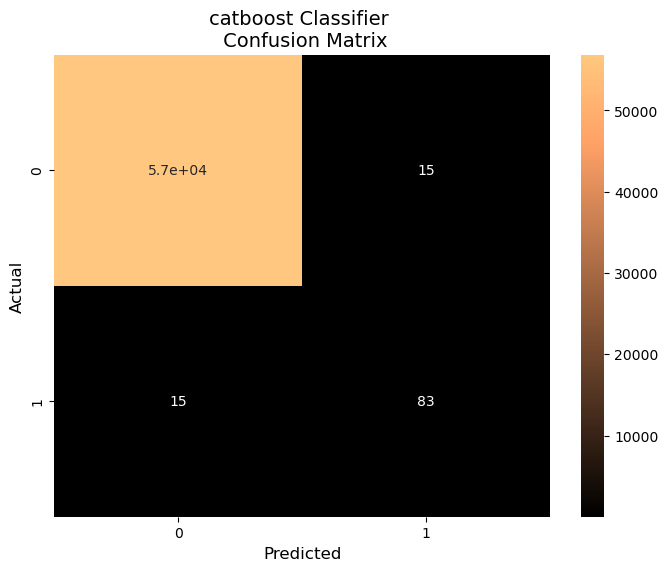

In [62]:
scores = final_model.fit(tune_x, tune_y,
                                 verbose=False,
                                 early_stopping_rounds=100,
                                 sample_weight=weight).predict_proba(test_x)
pred_labels = final_model.predict(test_x)

catboost_conf = confusion_matrix(test_y, pred_labels)

print(f"Confusion matrix on test set: \n")

plt.figure(figsize=(8, 6))
sns.heatmap(catboost_conf, annot=True, cmap=plt.cm.copper)
plt.title("catboost Classifier \n Confusion Matrix", fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.show()

precision, recall, thresholds = precision_recall_curve(test_y, scores[:,1])

threshold = np.append(thresholds,np.nan) # threshold are #precsion_scores-1

data_treshold = pd.DataFrame()
data_treshold['precision'] = precision
data_treshold['recall'] = recall
data_treshold['thresholds'] = threshold
data_treshold.to_csv('catboostTuning_data_treshold.csv', index=False)

In [11]:
parameters = ['depth', 'learning_rate', 'l2_leaf_reg', 'border_count', 'subsample', 'grow_policy']
results = pd.DataFrame()

In [23]:
for x in range(0,len(parameters)):
    values = [res[i]['misc']['vals'][parameters[x]][0] for i in range(0, len(res))]
    results[parameters[x]] = values
    results['recall'] = [res[i]['result']['recall'] for i in range(0, len(res))]
    results['precision'] = [res[i]['result']['precision'] for i in range(0, len(res))]
    results['f1_val'] = [res[i]['result']['f1_val'] for i in range(0, len(res))]
    results['f1_train'] = [res[i]['result']['f1_train'] for i in range(0, len(res))]
results['loss'] = trials.losses()
    
results.to_csv('catboostTuning_results.csv', index=False)

In [60]:
results = pd.read_csv("results/xgboostTuning_results.csv")

In [19]:
results.columns

Index(['depth', 'recall', 'precison', 'f1_val', 'f1_train', 'learning_rate',
       'l2_leaf_reg', 'border_count', 'subsample', 'grow_policy', 'loss'],
      dtype='object')

In [20]:
results['cum_loss'] = results.loss.cummin()

Text(0, 0.5, 'best_cumulative_score')

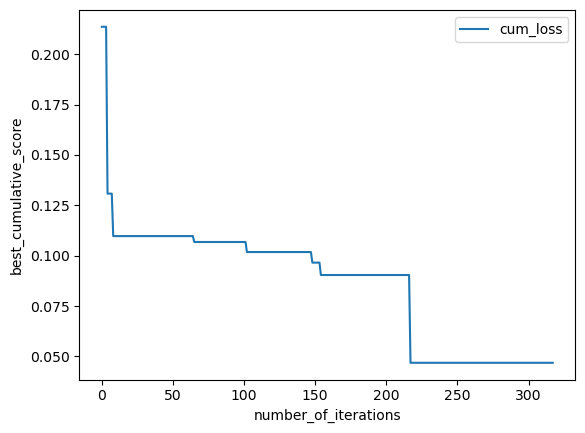

In [21]:
ax = results[['cum_loss']].plot()

ax.set_xlabel("number_of_iterations")
ax.set_ylabel("best_cumulative_score")

<Axes: >

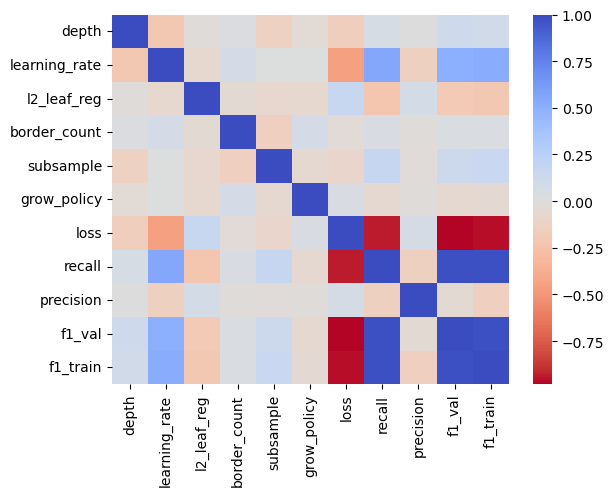

In [26]:
corr = results[['depth','learning_rate','l2_leaf_reg', 'border_count', 'subsample', 'grow_policy',
                'loss','recall', 'precision', 'f1_val', 'f1_train']].corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20})

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >], dtype=object)

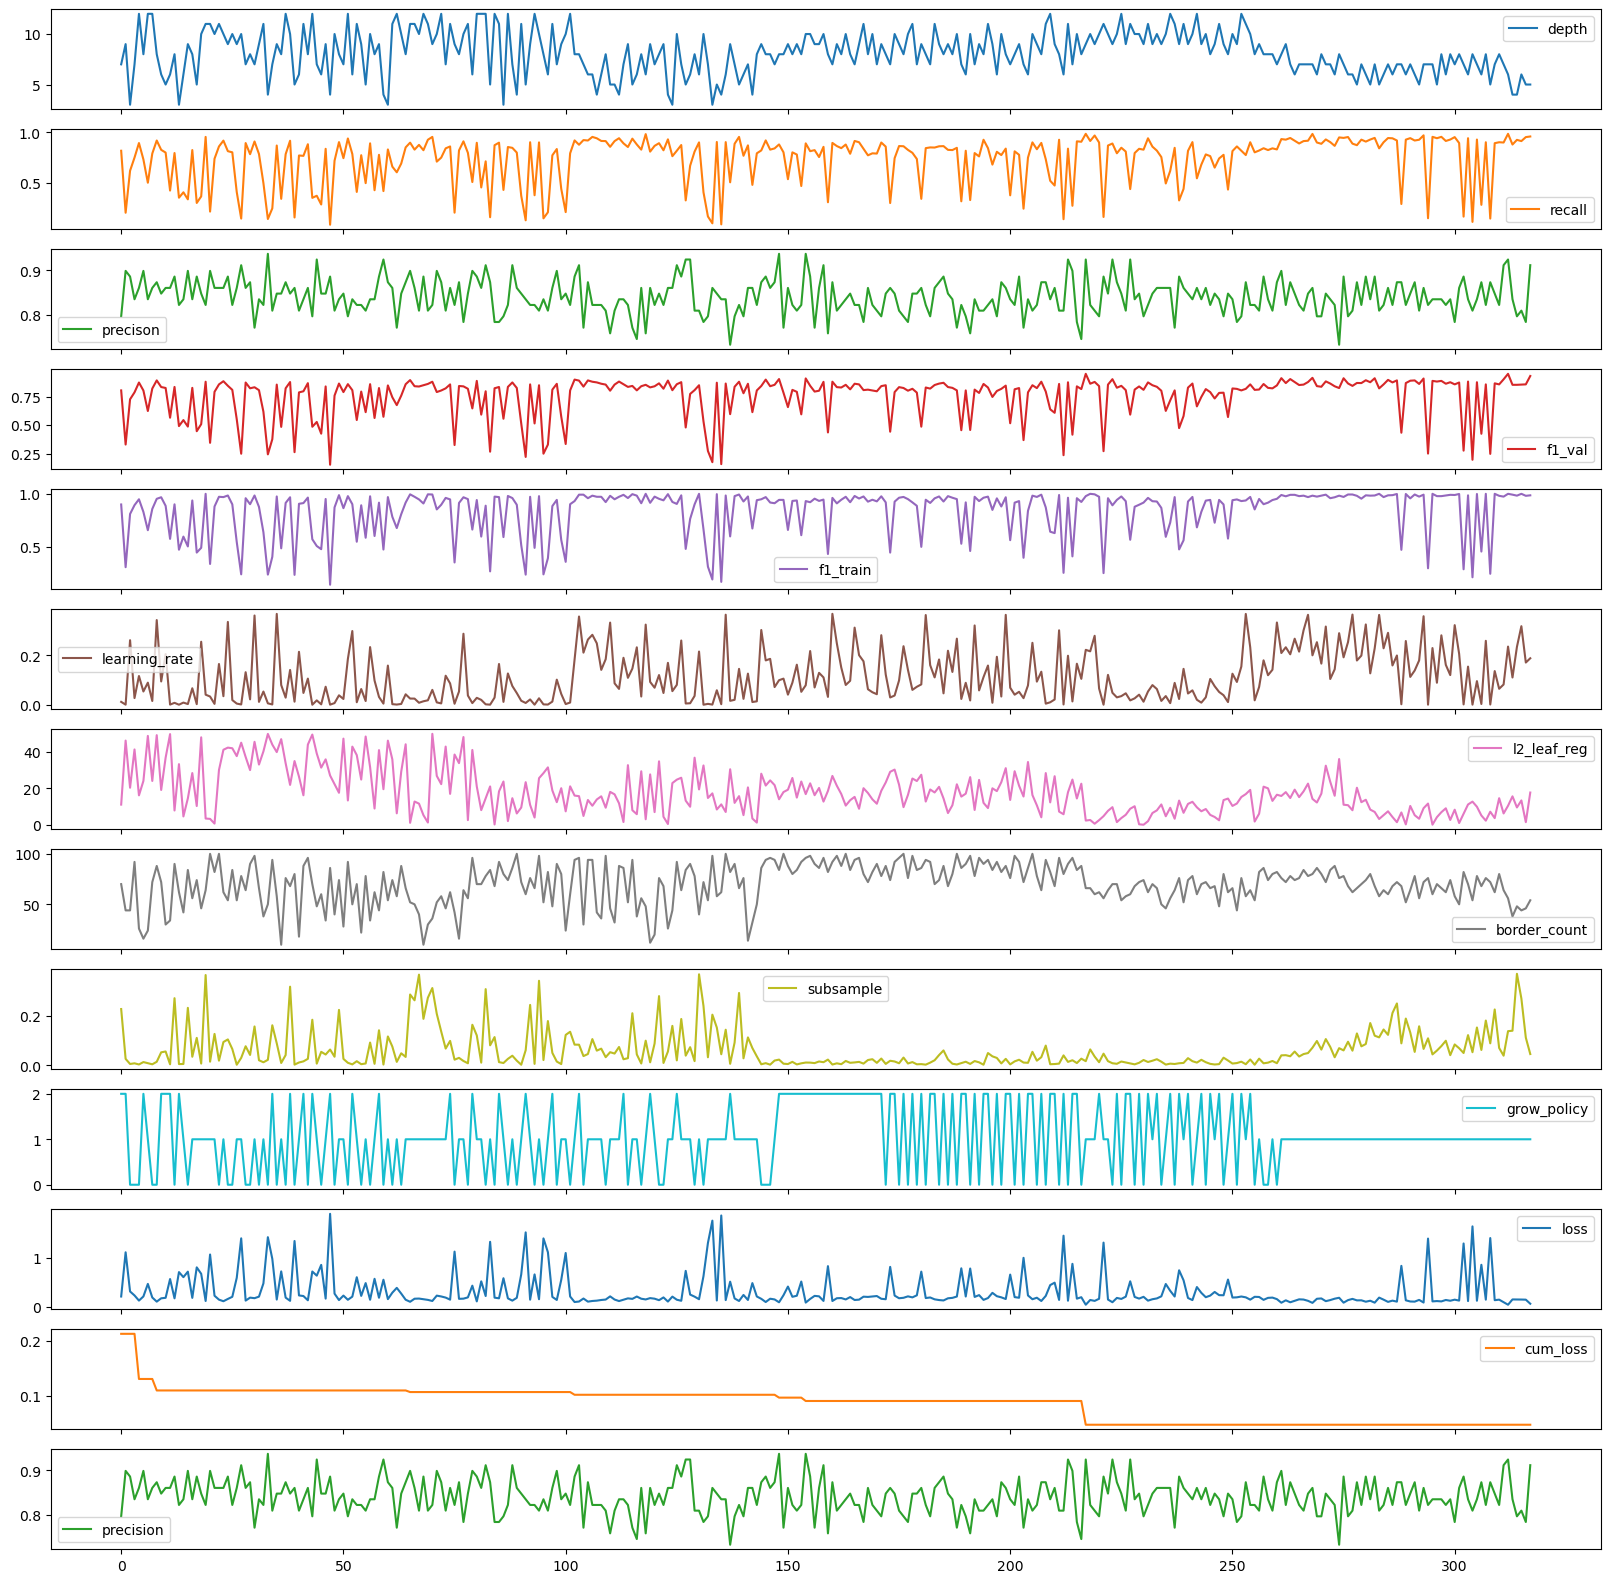

In [27]:
results.plot(subplots=True, figsize=(20, 20))

<Axes: xlabel='learning_rate', ylabel='subsample'>

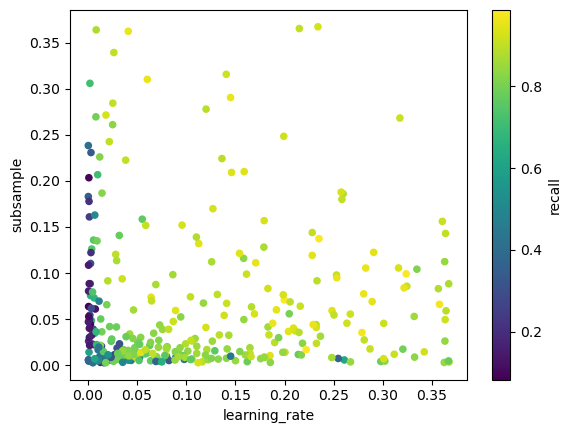

In [29]:
results.plot.scatter(x='learning_rate', y='subsample',c='recall')

In [30]:
results[['recall','precision','f1_val']].describe()

,recall,precision,f1_val
count,318.000000,318.000000,318.000000
mean,0.738504,0.841693,0.758611
std,0.238126,0.038820,0.180739
min,0.082547,0.734177,0.151025
25%,0.714429,0.822785,0.783276
50%,0.829268,0.835443,0.830189
75%,0.901408,0.860759,0.864865
max,0.986486,0.936709,0.954248
